<a href="https://colab.research.google.com/github/uyan21/deepLearningStudy/blob/main/smnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

음성을 인식하여 숫자 몇을 말하는지 파악할 수 있는가

In [52]:
#필요한 라이브러리 받는다
from google.colab import drive
drive.mount('/content/drive')
!pip install pydub
import tensorflow as tf
#데이터셋 다운로드 lib 임포트
import tensorflow_datasets as tfds
#RNN(LSTM) 레이어 모델 쓸거임
from keras.models import Sequential
from keras.layers import LSTM,Dense
#원-핫 인코딩 함수 임포트
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [53]:
#다운로드
ds=tfds.load('spoken_digit',shuffle_files=True)

In [54]:
#키 확인하고 데이터셋 분류한다
#(데이터 제공한사람이 대충만들어서train 밖에 없으므로 나중에 
#이안에서 train, test, val 나눈다)
print(ds.keys())
ds_train=ds['train']
#ds_train=ds_train.shuffle(1024)

dict_keys(['train'])


In [55]:
#데이터 전처리(사이즈 평균(5000정도됨)에 맞춰서 긴거는 짤리게 하지말고 그냥 사이즈 확 늘린다)
arrl=[]
for i in ds_train.as_numpy_iterator():
  arr=i['audio']
  arr=np.asarray(arr)
  arr=np.resize(arr,(10000,))
  arrl.append(arr)
x=np.asarray(arrl)
print(x.shape)

(2500, 10000)


In [56]:
#y데이터(답) 전처리
arrl=[]
for i in ds_train.as_numpy_iterator():
  y_=i['label']
  arrl.append(y_)
y=np.asarray(arrl)
print(y.shape)

(2500,)


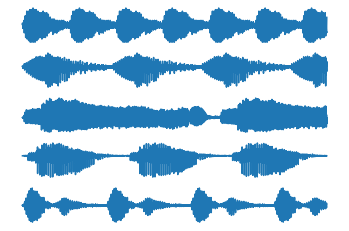

In [57]:
#주파수 시각화 해본다
k,a=plt.subplots(5)
for i in range(5):
  a[i].axis('off')
  a[i].plot(x[i])

plt.show()

In [58]:
#데이터 원-핫 인코딩
y=to_categorical(y)
print(y.shape)

(2500, 10)


In [59]:
#주파수 값차이가 좀 커서 정규화를 해야될 것 같음
#정규화 함수 정의
#정규화 영어스펠링 까먹어서 저렇게 씀
def nomaliza(dataset):
  arr=[]
  for i in dataset:
    arr.append((i - np.min(i)) / (np.max(i)-np.min(i)))
  arr=np.asarray(arr)
  return arr

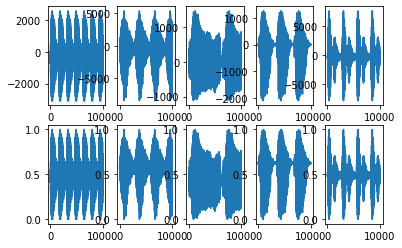

In [60]:
#정규화
x_n=nomaliza(x)
#정규화 전후 그래프 상의 차이가 있나 비교
k,a=plt.subplots(2,5)
for i in range(5):
  for j in range(2):
    if j==1:
      a[j,i].plot(x_n[i])
    else:
      a[j,i].plot(x[i])

plt.show()

In [61]:
#이제 훈련용, 테스트용, 비교용 나눈다
x=x_n
x_train=x[:2000]
x_tmp=x[2000:]
x_test=x_tmp[:400]
x_val=x_tmp[400:]
y_train=y[:2000]
y_tmp=y[2000:]
y_test=y_tmp[:400]
y_val=y_tmp[400:]
print(x_train.shape,x_test.shape,x_val.shape)
print(y_train.shape,y_test.shape,y_val.shape)

(2000, 10000) (400, 10000) (100, 10000)
(2000, 10) (400, 10) (100, 10)


In [62]:
#원래는 10000 시리얼 데이터인데 100,100 디멘션으로 나눈다
#학습을 빠르게 하기 위함
x_train=x_train.reshape(x_train.shape[0],100,100)
x_test=x_test.reshape(x_test.shape[0],100,100)
x_val=x_val.reshape(x_val.shape[0],100,100)
print(x_train.shape,x_test.shape,x_val.shape)

(2000, 100, 100) (400, 100, 100) (100, 100, 100)


In [63]:
#레이어 모델을 쌓는다
#레이어 3개만 쌓음
model = Sequential()

model.add(LSTM(128,input_shape=(100,100),return_sequences=True))
model.add(LSTM(64,return_sequences=False))
model.add(Dense(10,activation='softmax'))

#손실함수 mse쓰니까 정확도가 너무 안나옴
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=["accuracy"])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 100, 128)          117248    
_________________________________________________________________
lstm_7 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 167,306
Trainable params: 167,306
Non-trainable params: 0
_________________________________________________________________


In [64]:
#학습시작
hist=model.fit(x_train,y_train,epochs=100,batch_size=4,validation_data=(x_val,y_val))

Epoch 1/100
250/250 [==============================] - 22s 89ms/step - loss: 2.3248 - accuracy: 0.1105 - val_loss: 2.2912 - val_accuracy: 0.1700
Epoch 2/100
250/250 [==============================] - 22s 87ms/step - loss: 2.3089 - accuracy: 0.1080 - val_loss: 2.2986 - val_accuracy: 0.1000
Epoch 3/100
250/250 [==============================] - 22s 89ms/step - loss: 2.3021 - accuracy: 0.0995 - val_loss: 2.2847 - val_accuracy: 0.1200
Epoch 4/100
250/250 [==============================] - 22s 88ms/step - loss: 2.2962 - accuracy: 0.1210 - val_loss: 2.2672 - val_accuracy: 0.1300
Epoch 5/100
250/250 [==============================] - 23s 91ms/step - loss: 2.2923 - accuracy: 0.1175 - val_loss: 2.2564 - val_accuracy: 0.1800
Epoch 6/100
250/250 [==============================] - 22s 89ms/step - loss: 2.2723 - accuracy: 0.1290 - val_loss: 2.2384 - val_accuracy: 0.1800
Epoch 7/100
250/250 [==============================] - 22s 88ms/step - loss: 2.2746 - accuracy: 0.1360 - val_loss: 2.2488 - val_ac

In [65]:
#반복학습 1000번 시켜야 제대로된 훈련모델 어느정도 완성될 듯 함
model.evaluate(x_test,y_test)

13/13 [==============================] - 1s 40ms/step - loss: 1.8241 - accuracy: 0.2750


[1.8241450786590576, 0.2750000059604645]

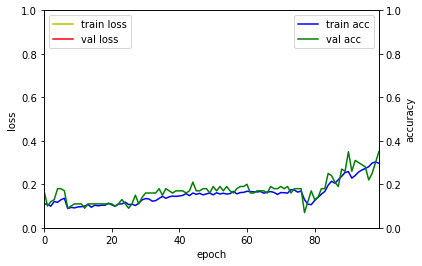

In [66]:
#100회 반복 약 40분 걸림 
#알파고급 학습 코스트
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()
loss_ax.axis([0,99,0,1])
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.axis([0,99,0,1])
acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper right')

plt.show()